In [1]:
## Creates pointclouds and vectorizations of persistence diagrams from the ModelNet dataset.
import sys
import pickle

#import pandas as pd
from copy import deepcopy
import numpy as np
import gudhi as gd
import argparse
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import trimesh as trm
import glob


import tensorflow as tf
import tensorflow.keras as keras
from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances

from tensorflow.keras.regularizers import l1, l2

import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec


import seaborn as sns



# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")
plt.style.use('ggplot')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
data_dir = "Data/ModelNet10/"
num_samples=1024
sample_even=False
normalize=True
global_bounding_box=False
n_boostrap = 30

file_structure = glob.glob(f"{data_dir}/**",recursive=False)
labels = [name.split("/")[-1] for name in file_structure]

test_dir  = [os.path.join(name, 'test') for name in file_structure]
train_dir = [os.path.join(name, 'train') for name in file_structure]

all_train_files = [os.listdir(name) for name in train_dir]
all_test_files  = [os.listdir(name) for name in test_dir]
N_train     = len(all_train_files)
N_test      = len(all_test_files)

## Loading the mesh data and creating the point clouds:
def create_pointclouds(list_files, directory, num_samples,
                       normalize=normalize, sample_even=sample_even,
                       choice_train=True):
    sample_fct = trm.sample.sample_surface
    if sample_even:
        sample_fct = trm.sample.sample_surface_even

    pcs = []
    # if choice_train:
    #     cur_dir = train_dir
    # else:
    #     cur_dir = test_dir

    for file in tqdm(list_files, desc=f'creating PCs for {directory.split("/")[-2]}'):
        mesh = trm.load(os.path.join(directory, file))
        pc = sample_fct(mesh, num_samples)[0]
        np.random.shuffle(pc)
        assert(pc.shape == (num_samples, 3) or sample_even)
        if normalize:
            pc -= np.mean(pc, axis=0, dtype=np.float64)
            MX = np.max(np.linalg.norm(pc, axis=1))
            pc /= MX
        pcs.append(pc)
    return pcs

In [4]:
pc_train = []
for class_ind in range(len(train_dir)):
    pcs = create_pointclouds(list_files=all_train_files[class_ind], directory = train_dir[class_ind], num_samples=num_samples,
                                      sample_even=sample_even, choice_train=True)
    pc_train = pc_train + pcs

creating PCs for dresser: 100%|███████████████| 200/200 [00:22<00:00,  8.74it/s]


In [5]:
buffer = np.array([[i, j] for i in np.arange(len(pc_train)) for j in np.arange(len(pc_train))])
buffer_id =  np.random.choice(len(buffer), 2500, replace = False)
train_indexes = buffer[buffer_id]

In [11]:
import pickle

# with open("Data/cross_ripsnet_3d_exp/3d_shapes_pc_train_2500_30_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(pc_train, fp)

# with open("Data/cross_ripsnet_3d_exp/3d_shapes_indexes_2500_30_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(train_indexes, fp)

In [12]:
n_boostrap = 30
train_PD = []
for i,j in tqdm(train_indexes):  
    barc = [mtd.calc_cross_barcodes(pc_train[i], pc_train[j], batch_size1 = 600, batch_size2 = 700, is_plot = False, pdist_device = "cuda") for _ in range(n_boostrap)]
    train_PD.append(barc)

100%|████████████████████████████████████| 2500/2500 [12:23:50<00:00, 17.85s/it]


In [13]:
# import pickle
# with open("Data/cross_ripsnet_3d_exp/3d_shapes_pds_2500_30_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(train_PD, fp)

In [7]:
# with open('Data/cross_ripsnet_3d_exp/3d_shapes_pds_2500_30_boostrap', 'rb') as fp:
#     train_PD = pickle.load(fp)
# with open("Data/cross_ripsnet_3d_exp/3d_shapes_indexes_2500_30_boostrap", 'rb') as fp:   #Pickling
#     train_indexes = pickle.load(fp)

In [4]:
with open('Data/cross_ripsnet_3d_exp/3d_shapes_pc_train_2500_30_boostrap', 'rb') as fp:
    pc_train = pickle.load(fp)

with open("Data/cross_ripsnet_3d_exp/3d_shapes_indexes_2500_30_boostrap", "rb") as fp:
    train_indexes = pickle.load(fp)

with open('Data/cross_ripsnet_3d_exp/3d_shapes_pds_2500_30_boostrap', 'rb') as fp:
    train_PD = pickle.load(fp)

with open("Data/cross_ripsnet_3d_exp/3d_shapes_PI_2500_30_boostrap", 'rb') as fp:   #Pickling
    PI_train_all = pickle.load(fp)

In [5]:
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

In [15]:
pds_train = DiagramSelector(use=True).fit_transform(train_PD_1[0])
vpdtr = np.vstack(pds_train)

for barcs in train_PD_1[1:]:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
# bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
# ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
# sigma = np.quantile(ppers, .2)
# im_bnds = [np.quantile(vpdtr[:,0],0.2), np.quantile(vpdtr[:,0],0.8), np.quantile(pers,0.2), np.quantile(pers,0.8)]
im_bnds = [np.min(vpdtr[:,0]), np.quantile(vpdtr[:,0],0.9), np.min(pers), np.max(pers)]

In [16]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_train_all = []
for barcs in tqdm(train_PD_1):
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    
    
    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .2)
    sigma = 0.01 if sigma < 1e-2 else sigma
    # print(sigma)

    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1]**3, 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
    PI_train = np.sum(PI_train,axis = 0)/n_boostrap
    PI_train = PI_train/np.sum(PI_train)
    PI_train_all.append(PI_train)
    
PI_train_all = np.array(PI_train_all)

100%|███████████████████████████████████████| 2500/2500 [17:54<00:00,  2.33it/s]


In [19]:
# with open("Data/cross_ripsnet_3d_exp/3d_shapes_PI_2500_30_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(PI_train_all, fp)

In [10]:
# with open("Data/cross_ripsnet_3d_exp/3d_shapes_PI_2500_30_boostrap", 'rb') as fp:   #Pickling
#     PI_train_all = pickle.load(fp)

### На этом датасете брать ккубическкую функцию в качестве весовой позволяет выделить важные признаки, увеличить разнообразие каартинок, убрать у каждой картинки схожие паттерны с персистенцией близкой к нулю

In [6]:
PI_train = np.vstack([PI_train_all[:2200]])
clean_PI_test = np.vstack([PI_train_all[2200:]])

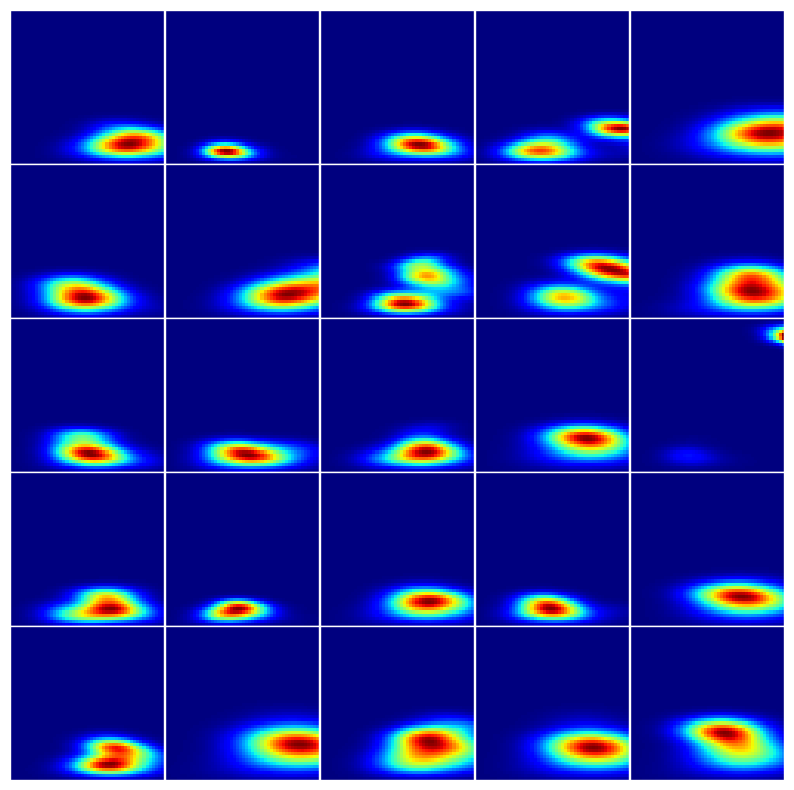

In [7]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(5, 5, width_ratios=[1,1,1,1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    for j in range(5):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train_all[400*i+j*80], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

In [8]:
from scipy.stats import entropy

def sym_KL(y_true, y_pred):
    loss = tf.keras.losses.KLDivergence()
    return (loss(y_true, y_pred) + loss(y_pred, y_true))/2

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=150, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)

optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
inputs_1 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)

x = DenseRagged(units=40, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=30, use_bias=True, activation='relu')(x)
x = DenseRagged(units=15, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=40, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=30, use_bias=True, activation='relu')(y)
y = DenseRagged(units=15, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=40, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=15, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)
## Добавить расстояния как фичи


z = keras.layers.Concatenate(axis=-1)([x, y, x_y])

z = tf.keras.layers.Normalization()(z)

z = tf.keras.layers.Dense(100,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.2)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.2)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.2)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1,inputs_2], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

2024-12-24 12:03:08.881023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 12:03:08.884100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19554 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [9]:
data_train_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[:2200]])
data_test_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[2200:]])


tf_data_train_1 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, :num_samples])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, num_samples:])] for i in range(len(data_train_concat))], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, :num_samples])] for i in range(len(data_test_concat))], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, num_samples:])] for i in range(len(data_test_concat))], ragged_rank=1)

2025-03-16 18:17:34.711166: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-16 18:17:35.982522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10464 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


2024-12-24 12:06:51.376505: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


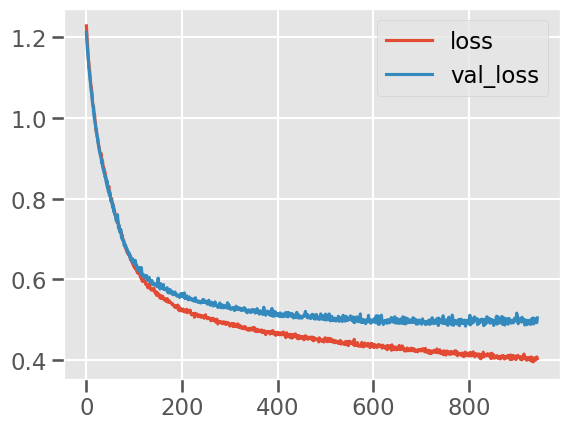

Model fitted for --- 908.8443329334259 seconds ---


In [24]:
import time

start_time = time.time()

history = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2], PI_train, epochs=2000, 
                       validation_data=([tf_data_test_1, tf_data_test_2], clean_PI_test), callbacks=[callback], verbose=0)


plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

train_PI_prediction = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2])
clean_PI_prediction = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2])

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

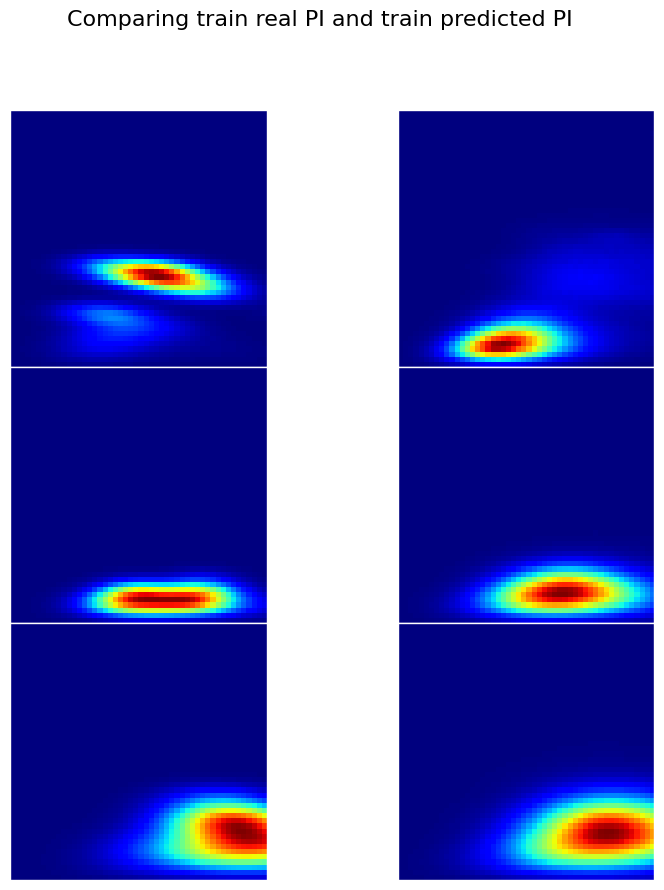

In [25]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

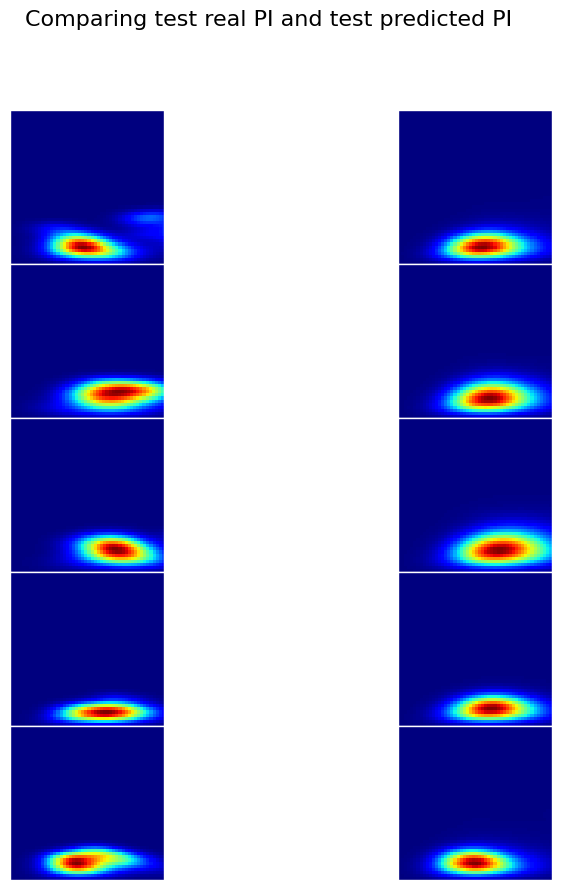

In [26]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[60*i+i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(clean_PI_prediction[60*i+i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

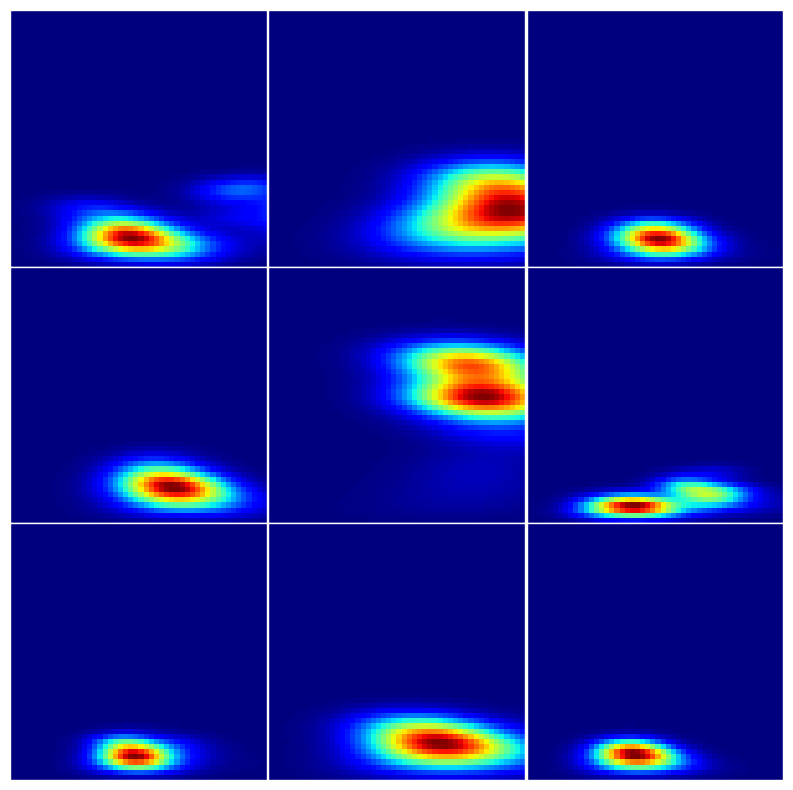

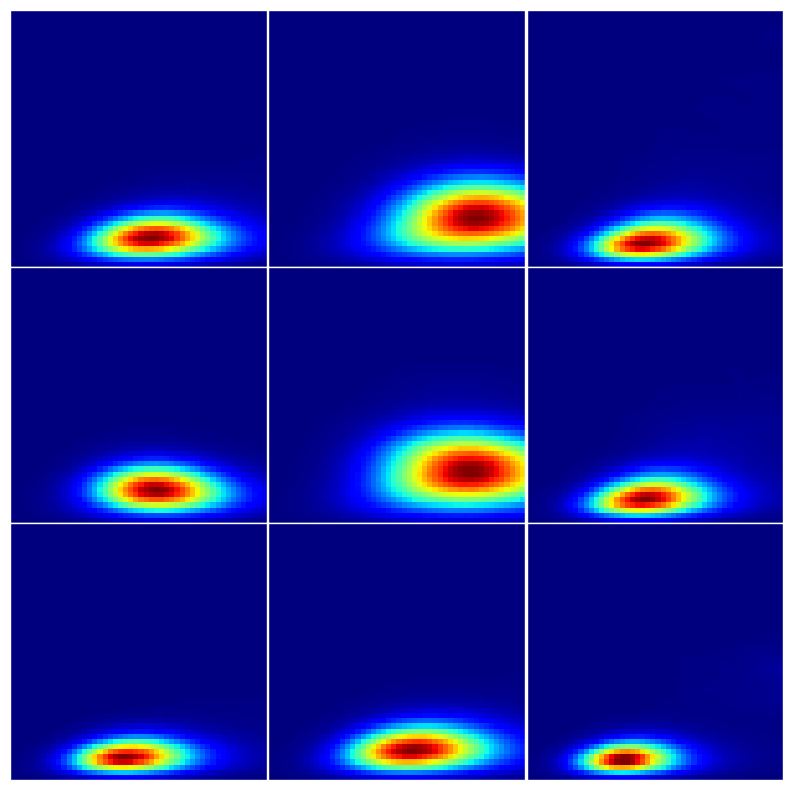

In [27]:
# fig = plt.figure(figsize=(10, 10)) 
# gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
# for i in range(3):
#     for j in range(3):
#         ax = plt.subplot(gs[i,j])
#         ax.scatter(tf_data_test_1[200*i+j,:,0], tf_data_test_1[200*i+j,:,1], s=3)
#         ax.scatter(tf_data_test_2[200*i+j,:,0], tf_data_test_2[200*i+j,:,1], s=3)
#         plt.xticks([])
#         plt.yticks([])
# # plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[20*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction[20*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

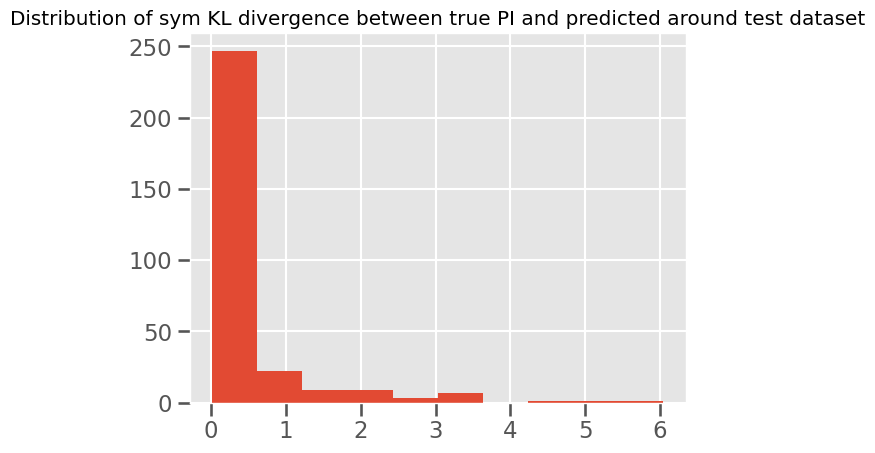

In [28]:
distances = measure_dist(clean_PI_test, clean_PI_prediction, method = "KL_sym")
plt.hist(distances)
plt.title("Distribution of sym KL divergence between true PI and predicted around test dataset")
plt.show()

### Let's check the model with distance matrix

In [10]:
N_points = num_samples

In [11]:
pdist_train = np.zeros((data_train_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_train_concat.shape[0]), desc = "pdist for train dataset"):
    cloud_1 = data_train_concat[i, :N_points]
    cloud_2 = data_train_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    # pdist_train.append(d)
    pdist_train[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist_test = np.zeros((data_test_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_test_concat.shape[0]), desc = "pdist for test dataset"):
    cloud_1 = data_test_concat[i, :N_points]
    cloud_2 = data_test_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    pdist_test[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist for test dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.07it/s]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150)
pdist_train_reducted_L = np.array([pca.fit_transform(cloud[:, :N_points]) for cloud in pdist_train])
print("ho")
pdist_train_reducted_R = np.array([pca.fit_transform(cloud[:, N_points:]) for cloud in pdist_train])
print("ho")
pdist_test_reducted_L = np.array([pca.fit_transform(cloud[:, :N_points]) for cloud in pdist_test])
print("ho")
pdist_test_reducted_R = np.array([pca.fit_transform(cloud[:, N_points:]) for cloud in pdist_test])

In [ ]:
pdist_train_reducted_L.shape

In [ ]:
print("hoho")

In [15]:
import time

n_features = 60
start_time = time.time()

percentiles = np.linspace(0, 100, n_features)

pdist_train_reducted_quant = tf.ragged.constant(
    [np.percentile(cloud, percentiles, axis=-1, interpolation = "nearest").transpose((1,0)) for cloud in pdist_train],
    ragged_rank=1)

pdist_test_reducted_quant = tf.ragged.constant(
    [np.percentile(cloud, percentiles, axis=-1, interpolation = "nearest").transpose((1,0)) for cloud in pdist_test], 
    ragged_rank=1)

# pdist_train_reducted_quant = tf.ragged.constant(np.random.randn(len(pdist_train), 40, n_features), ragged_rank=1)
# pdist_test_reducted_quant = tf.ragged.constant(np.random.randn(len(pdist_test), 40, n_features), ragged_rank=1)

print("Distance matrix reducted by Quantile for --- %s seconds ---" % (time.time() - start_time))

/tmp/ipykernel_1269/310576903.py:9: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  [np.percentile(cloud, percentiles, axis=-1, interpolation = "nearest").transpose((1,0)) for cloud in pdist_train],
/tmp/ipykernel_1269/310576903.py:13: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  [np.percentile(cloud, percentiles, axis=-1, interpolation = "nearest").transpose((1,0)) for cloud in pdist_test],


Distance matrix reducted by Quantile for --- 1101.3417620658875 seconds ---


In [17]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
#                                             patience=150, verbose=0, mode='auto', baseline=None, 
#                                             restore_best_weights=False)

# dropout_rate = 0.2
# optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
# inputs_1 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
# inputs_2 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
# inputs_dist_L = tf.keras.Input(shape=(N_points, 150), dtype ="float32", ragged=False)
# inputs_dist_R = tf.keras.Input(shape=(N_points, 150), dtype ="float32", ragged=False)


# x = DenseRagged(units=40, use_bias=True, activation='relu')(inputs_1)
# x = DenseRagged(units=30, use_bias=True, activation='relu')(x)
# x = DenseRagged(units=15, use_bias=True, activation='relu')(x)
# x = PermopRagged()(x)

# y = DenseRagged(units=40, use_bias=True, activation='relu')(inputs_2)
# y = DenseRagged(units=30, use_bias=True, activation='relu')(y)
# y = DenseRagged(units=15, use_bias=True, activation='relu')(y)
# y = PermopRagged()(y)

# x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
# x_y = DenseRagged(units=40, use_bias=True, activation='relu')(x_y)
# x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
# x_y = DenseRagged(units=15, use_bias=True, activation='relu')(x_y)
# x_y= PermopRagged()(x_y)
# ## Добавить расстояния как фичи

# d_l = DenseRagged(units=60, use_bias=True, activation='relu')(inputs_dist_L)
# d_l = DenseRagged(units=40, use_bias=True, activation='relu')(d_l)
# d_l = DenseRagged(units=30, use_bias=True, activation='relu')(d_l)
# d_l = PermopRagged()(d_l)

# d_r = DenseRagged(units=60, use_bias=True, activation='relu')(inputs_dist_R)
# d_r = DenseRagged(units=40, use_bias=True, activation='relu')(d_r)
# d_r = DenseRagged(units=30, use_bias=True, activation='relu')(d_r)
# d_r = PermopRagged()(d_r)


# z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d_l, d_r])

# z = tf.keras.layers.Dense(100,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(dropout_rate)(z)
# z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(dropout_rate)(z)
# z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
# # z = tf.keras.layers.Dropout(0.2)(z)
# outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
# outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
# outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
# model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist_L, inputs_dist_R], outputs=outputs)
# model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

patience=150
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                                            patience=patience, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)

dropout_rate = 0.2
optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
inputs_1 = tf.keras.Input(shape=(None, 3), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None, 3), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(None, n_features), dtype ="float32", ragged=True)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=20, use_bias=True, activation='relu')(d)
d = DenseRagged(units=10, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
z = tf.keras.layers.Normalization()(z)
z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

In [18]:
history = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant], PI_train, epochs=3000, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant], clean_PI_test), callbacks=[callback], verbose=1)

Epoch 1/3000
69/69 [==============================] - 5s 36ms/step - loss: 792.7856 - val_loss: 459.8467
Epoch 2/3000
69/69 [==============================] - 1s 17ms/step - loss: 414.5358 - val_loss: 291.2061
Epoch 3/3000
69/69 [==============================] - 1s 18ms/step - loss: 274.1331 - val_loss: 205.3910
Epoch 4/3000
69/69 [==============================] - 1s 17ms/step - loss: 195.4275 - val_loss: 149.3968
Epoch 5/3000
69/69 [==============================] - 1s 18ms/step - loss: 141.4200 - val_loss: 108.4263
Epoch 6/3000
69/69 [==============================] - 1s 17ms/step - loss: 101.3779 - val_loss: 77.6610
Epoch 7/3000
69/69 [==============================] - 1s 16ms/step - loss: 71.8573 - val_loss: 54.5561
Epoch 8/3000
69/69 [==============================] - 1s 17ms/step - loss: 49.8210 - val_loss: 37.3585
Epoch 9/3000
69/69 [==============================] - 1s 18ms/step - loss: 33.3626 - val_loss: 24.5799
Epoch 10/3000
69/69 [==============================] - 1s 17ms

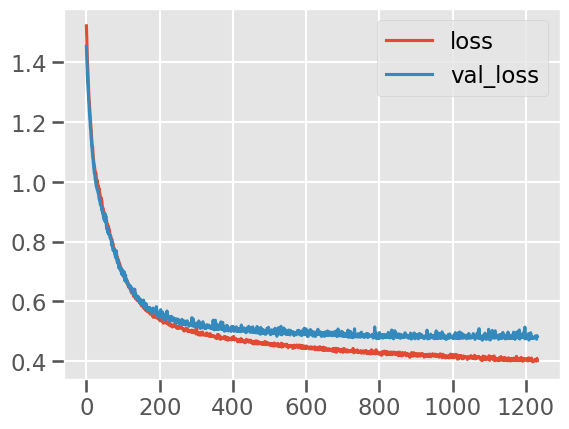

In [19]:
plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

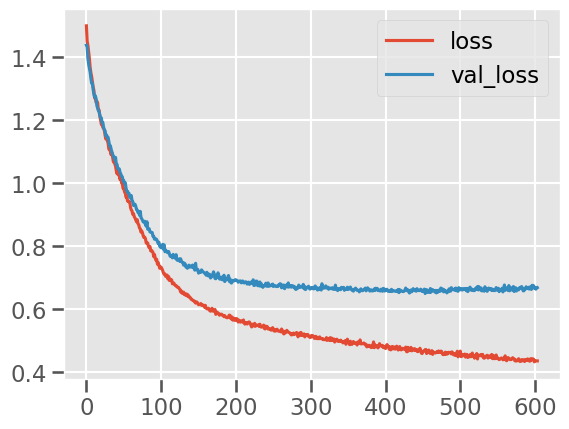

In [85]:
# plt.plot(np.array(history.history["loss"][20:]))
# plt.plot(np.array(history.history["val_loss"][20:]))
# plt.legend(["loss", "val_loss"])
# plt.show()

In [21]:
train_PI_prediction = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant])
clean_PI_prediction = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant])

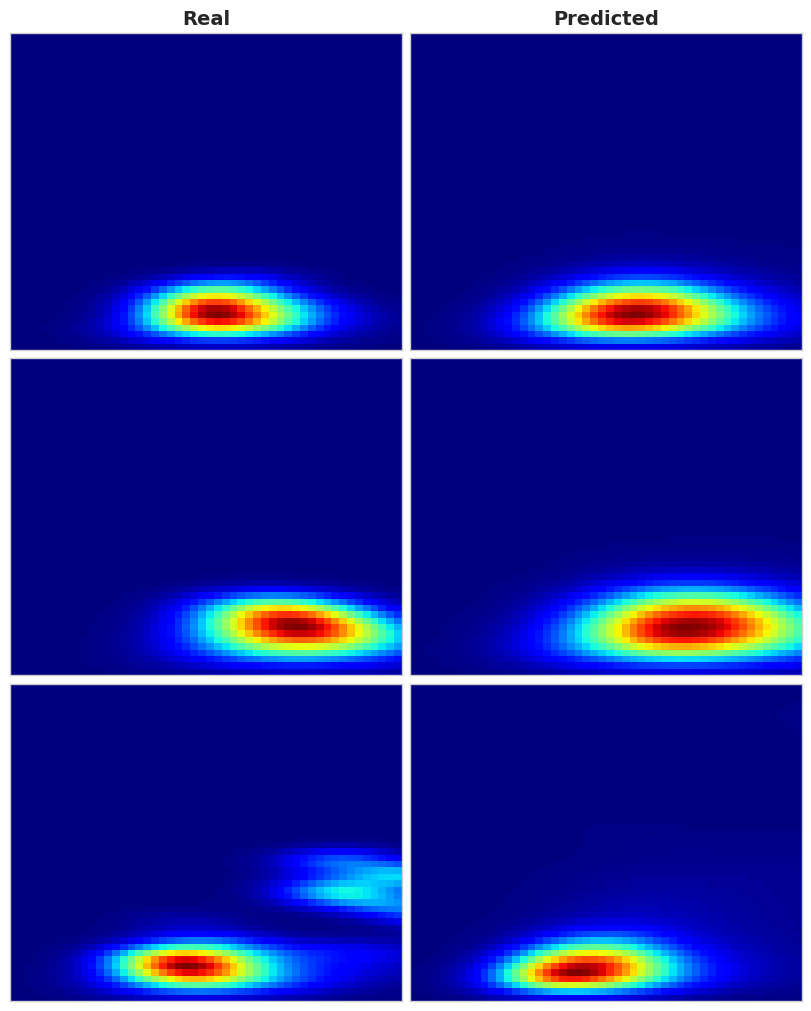

In [73]:
# Настройки стиля для статьи
plt.style.use('seaborn-v0_8-whitegrid')

# Размеры и параметры шрифта
fig, axes = plt.subplots(3, 2, figsize=(8, 10), constrained_layout=True)
# fig.suptitle("Comparison of Real and Predicted Density", fontsize=18, fontweight='bold')

for i in range(3):
    # Реальная плотность (левая колонка)
    ax = axes[i, 0]
    im = ax.imshow(np.flip(np.reshape(PI_train[200*i+2], (50,50)), 0), cmap='jet', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_title("Real", fontsize=14, fontweight='bold')
    
    # Предсказанная плотность (правая колонка)
    ax = axes[i, 1]
    im = ax.imshow(np.flip(np.reshape(train_PI_prediction[200*i+2], (50,50)), 0), cmap='jet', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_title("Predicted", fontsize=14, fontweight='bold')


# Сохранение графика в формате для статьи
plt.savefig("comparison_plot_3d_train.png", dpi=300)
plt.show()

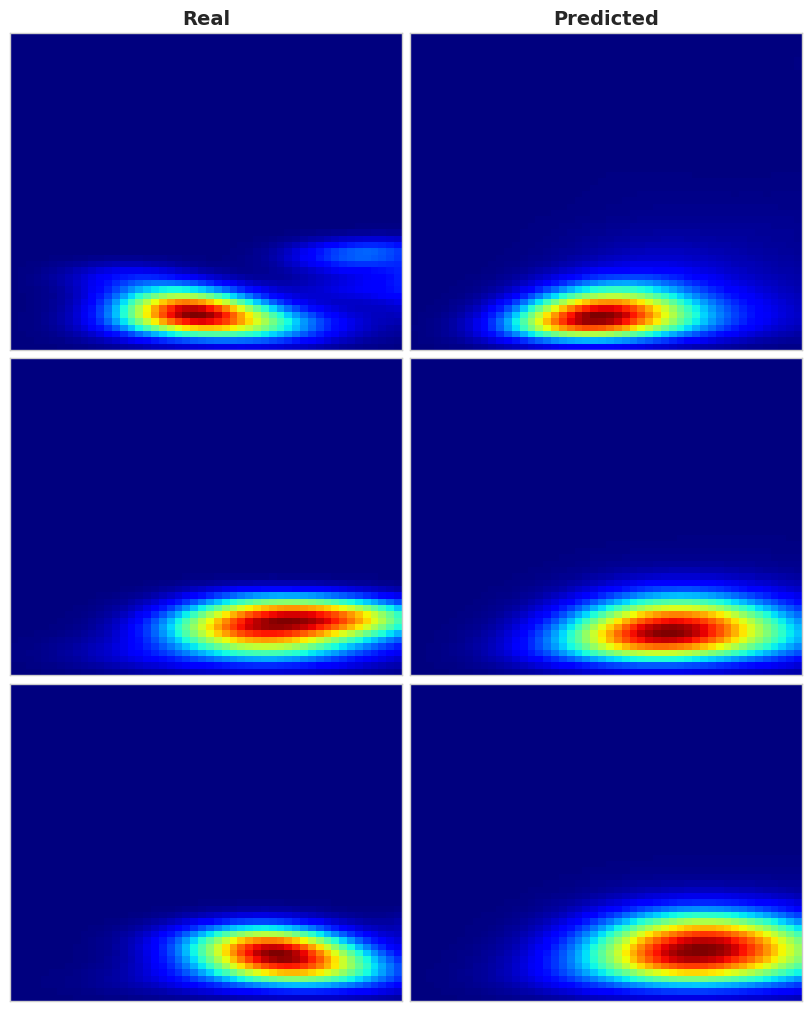

In [74]:
# Настройки стиля для статьи
plt.style.use('seaborn-v0_8-whitegrid')

# Размеры и параметры шрифта
fig, axes = plt.subplots(3, 2, figsize=(8, 10), constrained_layout=True)
# fig.suptitle("Comparison of Real and Predicted Density", fontsize=18, fontweight='bold')

for i in range(3):
    # Реальная плотность (левая колонка)
    ax = axes[i, 0]
    im = ax.imshow(np.flip(np.reshape(clean_PI_test[60*i+i], (50,50)), 0), cmap='jet', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_title("Real", fontsize=14, fontweight='bold')
    
    # Предсказанная плотность (правая колонка)
    ax = axes[i, 1]
    im = ax.imshow(np.flip(np.reshape(clean_PI_prediction[60*i+i], (50,50)), 0), cmap='jet', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_title("Predicted", fontsize=14, fontweight='bold')


# Сохранение графика в формате для статьи
plt.savefig("comparison_plot_3d_test.png", dpi=300)
plt.show()

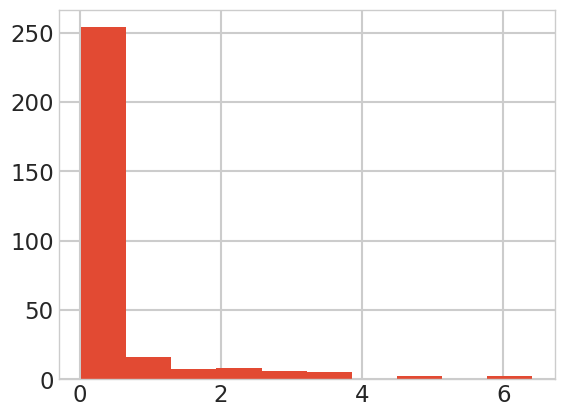

In [75]:
distances = measure_dist(clean_PI_test, clean_PI_prediction, method="KL")
plt.hist(distances)
plt.show()

In [77]:
np.mean(distances)

0.4621823561714468